## CNN

* https://paper.dropbox.com/doc/CNN-ZJvbCzAnDTYe71NH60HRI

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])


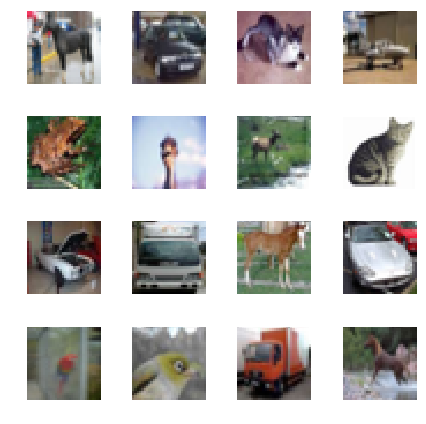

In [3]:
# CIFAR
train_loader, test_loader, classes = datasets.get_cifar_loader()
inputs,targets = next(iter(train_loader))
print(inputs.size())
utils.imgs.plot_rgb_samples(inputs)

## Im2col

* https://github.com/wiseodd/hipsternet/blob/master/hipsternet/im2col.py
* http://cs231n.github.io/convolutional-networks/#convert
* Convert a sliding window convolution into a single matrix multiplication by stretching out the filter

In [4]:
from utils.im2col import *


## Weight Initialization

* https://isaacchanghau.github.io/2017/05/24/Weight-Initialization-in-Artificial-Neural-Networks/
* https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network

In [212]:
def gaussian_init(dims):
    # Values are draw from normal distribution with mean 0 and variance 1
    return np.random.randn(*dims)

def uniform_init(low=-0.05, high=0.05, dims=None):
    # Values are draw from range [low, high) with equal probability
    # Includes low, excludes high
    return np.random.uniform(low, high, dims)

def xavier_init(X):
    pass

## Convolution Layer

* https://wiseodd.github.io/techblog/2016/07/16/convnet-conv-layer/
* https://github.com/zishansami102/CNN-from-Scratch/blob/master/CIFAR-10/convnet.py
* https://github.com/dreamgonfly/cnn-from-scratch
* https://github.com/utkarshojha/cnn-from-scratch/blob/master/cnn.py
* https://github.com/wiseodd/hipsternet/blob/master/hipsternet/layer.py
* http://gluon.mxnet.io/chapter04_convolutional-neural-networks/cnn-scratch.html

In [277]:
def pad(inp, padding):
    bs,c,h,w = inp.shape
    pad_inp = np.zeros((bs, c, h+2*padding, w+2*padding))
    pad_inp[:,:,padding:h+padding,padding:w+padding] = inp
    return pad_inp

def convolve_batch(batch, kernels, bias, padding, stride):
    bs,c,h,w = batch.shape
    n_ks,kc,kh,kw = kernels.shape
    assert c == kc
    #print("Batch", batch.shape, "Filters", kernels.shape)
    out_h = (h - kh + 2*padding) // stride + 1
    out_w = (w - kw + 2*padding) // stride + 1
    out = np.zeros((bs, n_ks, out_h, out_w))
    batch = pad(batch, padding)
    #print("Out", out.shape)
    for inp_idx, inp in enumerate(batch):
        for k_idx, kernel in enumerate(kernels):
            out[inp_idx][k_idx] = convolve(inp, kernel, bias[k_idx], stride)
    return out
    
def convolve(inp, kernel, bias, stride):
    c,h,w = inp.shape
    kc,kh,kw = kernel.shape
    assert c == kc
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((1, out_h, out_w))
    out_row = 0
    for row in range(0, h-kh+1, stride):
        out_col = 0
        for col in range(0, w-kw+1, stride):
            for chan in range(c):
                # Elementwise multiply then sum for sliding window approach
                # Same as dot product of two flattened vectors
                dp = inp[chan, row:row+kh, col:col+kw] * kernel[chan]
                dp = np.sum(dp) + bias
                out[0, out_row, out_col] += dp
            out_col += 1
        out_row += 1
    out += bias
    return out / kc

In [278]:
inp = np.ones((1,3,5,5))
kernels = gaussian_init((2,3,3,3))
bias = np.zeros((2,1,1))
out = convolve_batch(inp, kernels, bias, padding=1, stride=2)
out.shape, out

((1, 2, 3, 3), array([[[[ 0.39253801,  1.00595559,  1.94837336],
          [ 0.24180908,  0.73620394,  2.24011641],
          [-0.15914826,  0.17156337,  1.42455623]],
 
         [[-1.36776335, -1.16951882, -0.87506347],
          [-2.69924259, -2.4182388 , -2.1046959 ],
          [-3.22078265, -3.02160847, -1.81999124]]]]))

In [279]:
class Convolution():
    def __init__(self, in_chans, n_filters, fs=(3,3), 
                 stride=1, padding=1, init=gaussian_init):
        self.filters = init((n_filters, in_chans, fs[0], fs[1]))
        self.bias = np.zeros((n_filters, 1, 1, 1))
        self.stride = stride
        self.padding = padding
        
    def forward(self, X):
        return convolve_batch(X, self.filters, self.bias, self.padding, self.stride)
        
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [280]:
conv = Convolution(in_chans=3, n_filters=2, fs=(3,3), stride=1, padding=1)
inp = np.ones((1,3,5,5))
conv(inp)

array([[[[-0.59153553, -0.78429936, -0.78429936, -0.78429936, -0.21972756],
         [ 0.6147784 ,  0.0892825 ,  0.0892825 ,  0.0892825 ,  0.05055177],
         [ 0.6147784 ,  0.0892825 ,  0.0892825 ,  0.0892825 ,  0.05055177],
         [ 0.6147784 ,  0.0892825 ,  0.0892825 ,  0.0892825 ,  0.05055177],
         [ 1.59854865,  1.26637342,  1.26637342,  1.26637342,  0.48747229]],

        [[-0.68209747, -0.42055788, -0.42055788, -0.42055788, -0.61205315],
         [-0.25572615, -0.62420853, -0.62420853, -0.62420853, -1.13984954],
         [-0.25572615, -0.62420853, -0.62420853, -0.62420853, -1.13984954],
         [-0.25572615, -0.62420853, -0.62420853, -0.62420853, -1.13984954],
         [-0.5314688 , -1.10949861, -1.10949861, -1.10949861, -1.04137722]]]])

## MaxPooling Layer

In [281]:
def pool_batch(batch, ksize, stride):
    bs, c, h, w = batch.shape
    kh, kw = ksize
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((bs, c, out_h, out_w))
    for idx, inp in enumerate(batch):
        out[idx,:,:,:] = pool(inp, ksize, stride)
    return out

def pool(inp, ksize, stride):
    c, h, w = inp.shape
    kh, kw = ksize
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((c, out_h, out_w))
    out_row = 0
    for row in range(0, h-kh+1, stride):
        out_col = 0
        for col in range(0, w-kw+1, stride):
            out_pool = np.amax(inp[:, row:row+kh, col:col+kw], axis=(1,2))
            out[:, out_row, out_col] = out_pool
            out_col += 1
        out_row += 1
    return out

In [282]:
inp = gaussian_init((1,2,4,4))
ksize = (2,2)
stride = 2
out = pool_batch(inp, ksize, stride)
inp,out

(array([[[[  6.54065960e-01,  -1.60081766e+00,  -2.55357416e-02,
             5.77762910e-01],
          [ -1.44092623e+00,   1.80434351e-01,  -7.21273480e-01,
             6.03581084e-01],
          [  4.23811274e-01,  -1.25117346e+00,   1.48082032e+00,
             2.59465972e-02],
          [ -8.62073671e-01,   1.20765168e+00,   2.12270535e+00,
            -1.09034793e+00]],
 
         [[ -5.37120789e-02,  -3.31799428e-01,  -3.40365504e-01,
            -4.64808016e-01],
          [  2.10881022e-04,   1.99801689e-01,   6.86674279e-01,
            -1.47829344e-01],
          [  2.46958441e-01,  -5.03111193e-01,  -2.13867114e+00,
            -1.30806026e+00],
          [ -1.92140561e+00,   8.84890763e-01,   6.51444689e-01,
             3.39714772e-01]]]]), array([[[[ 0.65406596,  0.60358108],
          [ 1.20765168,  2.12270535]],
 
         [[ 0.19980169,  0.68667428],
          [ 0.88489076,  0.65144469]]]]))

In [283]:
class MaxPool():
    def __init__(self, ksize=(2,2), stride=2):
        self.ksize = ksize
        self.stride = stride
    
    def forward(self, X):
        return pool_batch(X, self.ksize, self.stride)
    
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [284]:
maxpool = MaxPool(ksize=(2,2), stride=2)
inp = gaussian_init((2,2,4,4))
maxpool(inp)

array([[[[ 0.29325416,  1.62739338],
         [ 0.67864654,  1.49331673]],

        [[ 0.61067017,  0.92172289],
         [ 0.80103484, -0.06990235]]],


       [[[-0.49488972,  1.89618881],
         [ 0.28165223,  1.38747003]],

        [[ 0.79388   ,  1.08974608],
         [ 1.88834101,  0.8665911 ]]]])

## Activation Layer

In [285]:
class ReLU():
    def __init__(self):
        pass
    
    def forward(self, X):
        return np.maximum(0, X)
    
    def backward(self, X):
        X = X.copy()
        X[X < 0] = 0
        X[X > 0] = 1
        return Z
    
    def __call__(self, X):
        return self.forward(X)

class Sigmoid():
    def __init__(self):
        pass
    
    def forward(self, X):
        return self._sigmoid(X)
    
    def backward(self, X):
        return self._sigmoid(X) * (1 - self._sigmoid(X))
        
    def _sigmoid(self, X):
        return 1.0 / (1 + np.exp(-X))
    
    def __call__(self, X):
        return self.forward(X)

In [286]:
inp = gaussian_init((2,2,4,4))
relu = ReLU()
relu(inp)

array([[[[ 0.        ,  0.18330875,  0.09064059,  0.        ],
         [ 1.32220269,  0.51552682,  2.32887609,  2.08411639],
         [ 1.44297827,  1.4315042 ,  0.        ,  1.07737807],
         [ 0.4356042 ,  0.29683006,  0.        ,  1.77522058]],

        [[ 3.33819692,  0.        ,  0.        ,  1.87571766],
         [ 0.        ,  0.        ,  0.19250714,  0.        ],
         [ 2.33685021,  0.        ,  0.        ,  0.        ],
         [ 1.06339451,  2.1954289 ,  2.11826253,  0.91681877]]],


       [[[ 0.        ,  0.        ,  0.        ,  1.56717949],
         [ 0.33649167,  0.        ,  0.        ,  0.05461805],
         [ 0.58721707,  0.87198568,  0.        ,  0.        ],
         [ 1.10183213,  0.86432979,  0.478962  ,  0.0586524 ]],

        [[ 0.67600985,  0.        ,  0.        ,  0.        ],
         [ 1.44979724,  0.11419711,  0.43667718,  0.        ],
         [ 0.        ,  0.        ,  0.52774544,  0.        ],
         [ 0.        ,  0.        ,  0.        

In [287]:
inp = gaussian_init((2,2,4,4))
sigmoid = Sigmoid()
sigmoid(inp)

array([[[[ 0.59057022,  0.12365567,  0.4606749 ,  0.68768932],
         [ 0.75730192,  0.46987313,  0.50760247,  0.54524729],
         [ 0.37722544,  0.61559001,  0.26750124,  0.66739557],
         [ 0.29638589,  0.35264298,  0.08874419,  0.45082522]],

        [[ 0.66974633,  0.33270363,  0.57787346,  0.1165916 ],
         [ 0.56981236,  0.08820915,  0.74766815,  0.43969968],
         [ 0.57118115,  0.46639956,  0.75454172,  0.29940633],
         [ 0.15662447,  0.74244577,  0.24460919,  0.56970538]]],


       [[[ 0.50916316,  0.3460019 ,  0.79322128,  0.19847675],
         [ 0.25090826,  0.37493058,  0.77919726,  0.48802905],
         [ 0.8824653 ,  0.54361202,  0.38776856,  0.48229682],
         [ 0.33723766,  0.38561754,  0.25440225,  0.3663235 ]],

        [[ 0.62011644,  0.66392158,  0.56314564,  0.47138623],
         [ 0.67890461,  0.5926009 ,  0.55168104,  0.08682268],
         [ 0.13098673,  0.29711464,  0.23459244,  0.89231881],
         [ 0.59106108,  0.29621524,  0.39514808

## Dropout

* https://github.com/wiseodd/hipsternet/blob/master/hipsternet/layer.py#L70

In [288]:
def dropout_batch():
    pass
    
def dropout():
    # https://github.com/wiseodd/hipsternet/blob/master/hipsternet/layer.py#L70
    pass

In [289]:
class Dropout():
    def __init__(self):
        pass
    
    def forward(self, X):
        return X
    
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [290]:
dropout = Dropout()
x = np.array([2])
dropout(x)

array([2])

## Linear

In [291]:
def flatten(X):
    bs = X.shape[0]
    return X.reshape((bs,-1))

In [292]:
class Linear():
    def __init__(self, in_feats, out_feats, init=uniform_init):
        self.weights = init(dims=(in_feats, out_feats))
        self.bias = np.array([1.0])
        self.out_feats = out_feats
    
    def forward(self, X):
        assert len(X.shape) == 2
        return X @ self.weights + self.bias
        
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [293]:
inp = np.random.randn(1,128)
linear = Linear(in_feats=128, out_feats=12)
linear(inp)

array([[ 0.85134008,  0.93616116,  0.71438621,  1.77926589,  0.52842985,
         0.88302268,  0.61329349,  0.74209306,  0.97715432,  0.72131699,
         1.14916701,  1.07679945]])

## Model

In [294]:
class CNN():
    def __init__(self, input_dims):
        c,h,w = input_dims
        self.conv = Convolution(in_chans=c, n_filters=3, stride=1, padding=1)
        self.relu = ReLU()
        self.dropout = Dropout()
        self.maxpool = MaxPool(ksize=(2,2), stride=2)
        self.linear = Linear(in_feats=(h//2) * (w//2) * 3, out_feats=12)
        self.sigmoid = Sigmoid()
    
    def forward(self, X):
        out = self.conv(X)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        out = flatten(out)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out
    
    def __call__(self, X):
        return self.forward(X)

In [295]:
inp = np.random.randn(1,3,8,8)
model = CNN(input_dims=(3,8,8))
model(inp)

array([[ 0.82184131,  0.62588099,  0.82396301,  0.71710467,  0.74010491,
         0.68618419,  0.78985766,  0.79255353,  0.74754803,  0.67870433,
         0.62920639,  0.87300313]])

## Train

## PyTorch

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_shape, n_classes):
        super().__init__()
        c,w,h = in_shape
        n_pool = 3
        w = int(w / 2**n_pool)
        h = int(h / 2**n_pool)
        self.features = nn.Sequential(
            nn.Conv2d(c, 8, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*w*h, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Train

In [ ]:
model = CNN(in_shape=(3,32,32), n_classes=10).cuda()

In [ ]:
inputs,targets = next(iter(train_loader))
output = model(Variable(inputs.cuda()))
output.size()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
lr_adjuster = learning_rates.FixedLR(initial_lr=1e-3, iteration_type='epoch')
trainer = training.QuickTrainer()
trainer.run(model, train_loader, test_loader, criterion, optimizer, epochs=10)

In [ ]:
plt.plot(np.stack([trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst']], 1))

## Sources

* https://github.com/bfortuner/ml-study/blob/master/NeuralNetworkReLU.ipynb
* https://wiseodd.github.io/techblog/2016/07/16/convnet-conv-layer/
* http://cs231n.github.io/convolutional-networks/